In [ ]:
import random
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve

[1] (аналогично Заданию 2) Используя make_blobs с любым random_state,
сгенерировать датасет df, в котором есть три класса с размером каждого класса
100, четыре количественных (недискретных) признака ,а центры классов
зафиксированы в следующих точках: Класс 0 – (+1, +1, +1, +1), Класс 1 – (-1,-1,-1,-
1), Класс 2 – (-1,+1,-1,+1).

In [ ]:
X, Y = make_blobs(centers=[[1, 1, 1, 1], [-1, -1, -1, -1], [-1, 1, -1, 1]], n_samples=300, random_state=43)
df = pd.DataFrame(X)
df['target'] = Y
df = (df.sort_values(by='target')
        .reset_index(drop=True))

display(df)

,0,1,2,3,target
0,1.478579,2.179589,0.428584,1.766579,0
1,0.405044,0.418730,0.344106,1.925149,0
2,-0.028273,2.363170,-0.142275,-0.372025,0
3,0.587507,0.255467,-0.172097,-0.760276,0
4,1.851791,1.958673,0.373516,1.307931,0
...,...,...,...,...,...
295,-1.149153,-1.042022,-0.732779,1.246038,2
296,-0.086971,1.786622,-0.373225,-0.939931,2
297,-0.810950,0.560522,-1.023482,0.895770,2
298,-0.483187,1.542111,-0.383621,2.190484,2


[2] Не забываем повторять шаги с задания 1
- ключевые характеристики датасета, корреляции, визуализация на всех парах var

In [ ]:
feature_columns = [col for col in df.columns if col not in ['target', 'id']]
display(df.describe())

statistics = {"Shape": f"({df.shape[0]}, {df.shape[1]})",
              "Features": len(feature_columns),
              "Classes": df['target'].nunique(),
              "Entries": f"{df['target'].value_counts().reset_index()['count'].tolist()}",
              # "Missing": f"{[str((df[i].isnull().sum() / len(df[i])) * 100) for i in feature_columns]}",
              "Missing": f'{df.isnull().mean().sum() * 100} %'}

df_statistics = pd.DataFrame(statistics, index=[0])
display(df_statistics)

,0,1,2,3,target
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,-0.245062,0.249373,-0.332492,0.393811,1.000000
std,1.386653,1.375645,1.299778,1.375347,0.817861
min,-3.382163,-3.403100,-3.961070,-3.494863,0.000000
25%,-1.313500,-0.584280,-1.240899,-0.594653,0.000000
50%,-0.430030,0.400144,-0.471537,0.559170,1.000000
75%,0.874197,1.300516,0.598163,1.456862,2.000000
max,3.713480,3.344858,3.909533,3.365988,2.000000


,Shape,Features,Classes,Entries,Missing
0,"(300, 5)",4,3,"[100, 100, 100]",0.0 %


In [ ]:
correlation_matrix = df.corr()

print("Dataset correlation matrix:")
display(correlation_matrix)

for class_value in df['target'].unique():
    class_df = df[df['target'] == class_value].drop(columns=['target'])
    corr_matrix_class = class_df.corr()

    print(f'\nCorrelation matrix for class {class_value}:')
    display(corr_matrix_class)

Dataset correlation matrix:


,0,1,2,3,target
0,1.000000,0.205444,0.451981,0.205413,-0.613861
1,0.205444,1.000000,0.248350,0.493971,-0.006039
2,0.451981,0.248350,1.000000,0.236703,-0.540592
3,0.205413,0.493971,0.236703,1.000000,0.009816
target,-0.613861,-0.006039,-0.540592,0.009816,1.000000



Correlation matrix for class 0:


,0,1,2,3
0,1.000000,-0.067435,0.097227,-0.055222
1,-0.067435,1.000000,-0.143929,0.028574
2,0.097227,-0.143929,1.000000,0.060158
3,-0.055222,0.028574,0.060158,1.000000



Correlation matrix for class 1:


,0,1,2,3
0,1.000000,-0.042778,-0.001995,-0.035880
1,-0.042778,1.000000,0.114943,-0.086807
2,-0.001995,0.114943,1.000000,-0.001966
3,-0.035880,-0.086807,-0.001966,1.000000



Correlation matrix for class 2:


,0,1,2,3
0,1.000000,-0.045197,-0.005401,-0.033674
1,-0.045197,1.000000,0.144621,-0.082025
2,-0.005401,0.144621,1.000000,0.006644
3,-0.033674,-0.082025,0.006644,1.000000


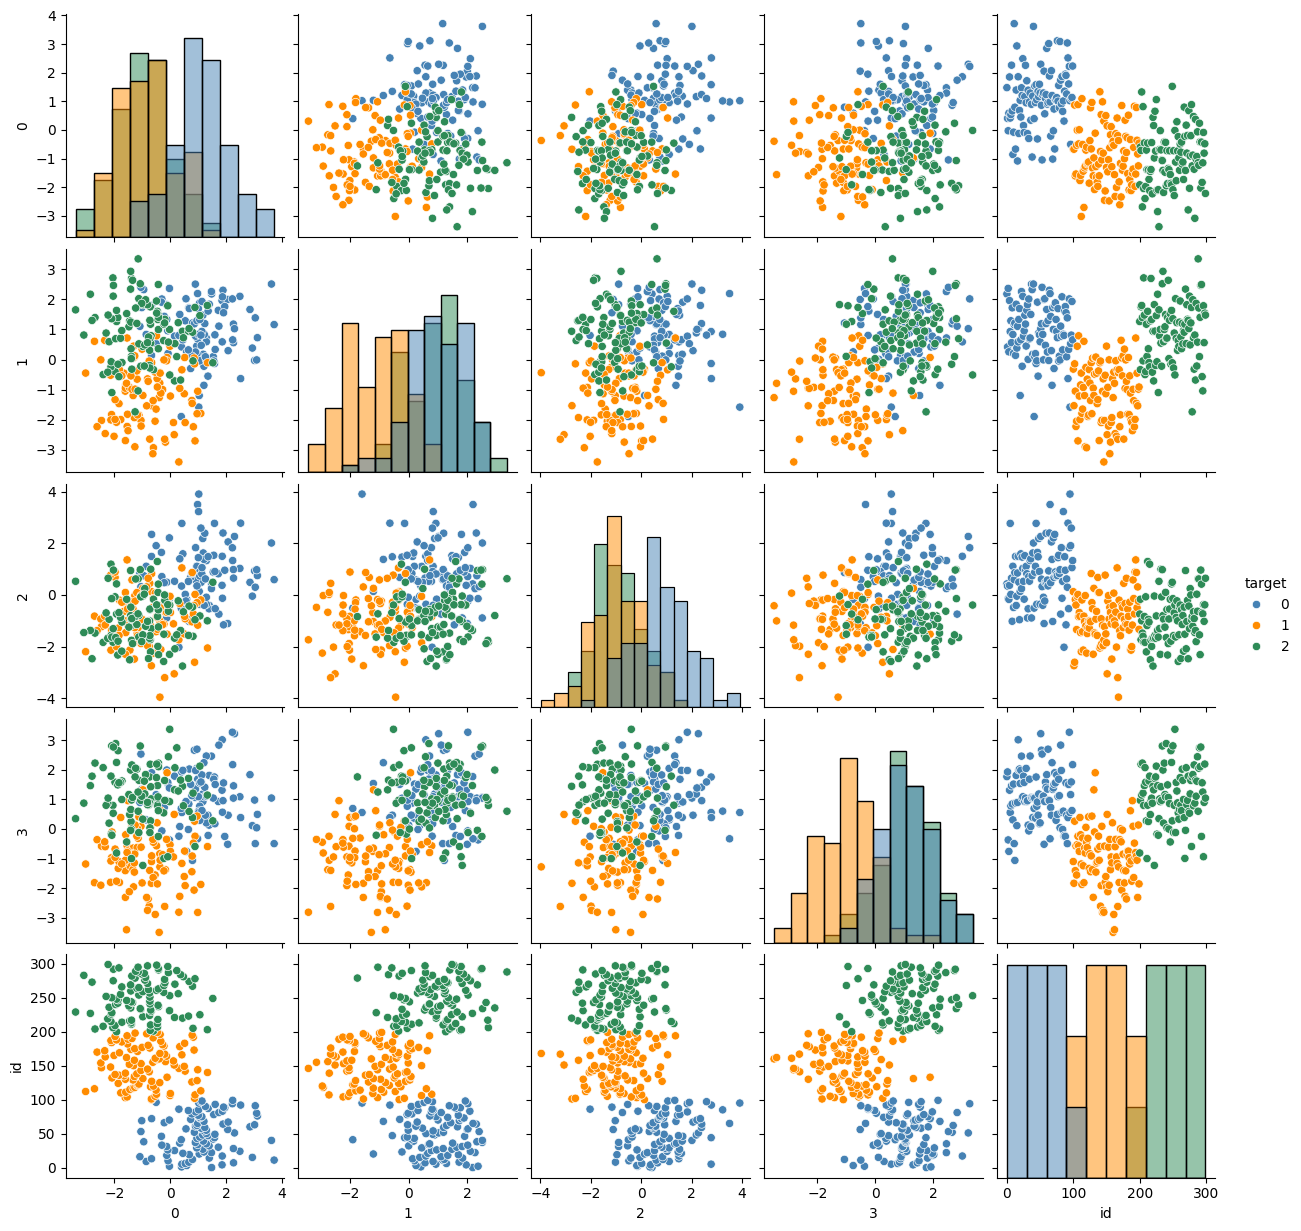

In [ ]:
df['id'] = df.index

sns.pairplot(df, hue='target', palette=['steelblue', 'darkorange', 'seagreen'], diag_kind='hist')
plt.show()

[3] На основе созданного в пункте [1] датасета сгенерировать отдельные
дополнительные датасеты (df_A_B), в которых к классу 0 добавлено A одинаковых
точек с координатами (+B,-B,+B,-B), где A = 1, 10, 100 и B = 5, 10, 20, при этом
количество объектов в остальных классах неизменно.

In [ ]:
def outweight_class(a, b, target=0):
    target_df = df[df['target'] == target]
    points_df = pd.DataFrame({
        0: [+b] * a,
        1: [-b] * a,
        2: [+b] * a,
        3: [-b] * a,
        'target': target * a
    })
    outweighted_df = pd.concat([target_df, points_df], ignore_index=True)
    non_target_df = df[df['target'] != target]
    return pd.concat([non_target_df, outweighted_df], ignore_index=True)


df_multipliers_A = [1, 10, 100]
df_coords_B = [5, 10, 20]

repeat_df_dict = {}
for a in df_multipliers_A:
    for b in df_coords_B:
        m = (a, b)
        repeat_df_dict[m] = outweight_class(a, b)

outweighted_df = repeat_df_dict[(100,5)]

display(outweighted_df)
outweighted_df['target'].value_counts()

,0,1,2,3,target,id
0,-0.667556,-0.318334,0.126890,-1.102583,1,100.0
1,-0.674033,-1.533559,-2.743098,-1.836409,1,101.0
2,0.870688,-0.143039,-2.607557,0.260638,1,102.0
3,-1.606999,-1.050872,-0.176450,-1.409943,1,103.0
4,-1.538903,-2.224301,-0.391496,-0.573661,1,104.0
...,...,...,...,...,...,...
395,5.000000,-5.000000,5.000000,-5.000000,0,NaN
396,5.000000,-5.000000,5.000000,-5.000000,0,NaN
397,5.000000,-5.000000,5.000000,-5.000000,0,NaN
398,5.000000,-5.000000,5.000000,-5.000000,0,NaN


,count
target,
0,200
1,100
2,100


[4] Выбрать пару классов (включая класс с повторенными объектами) и один
количественный признак.
Для каждого из датасетов df и df_A_B в своем пространстве Х-Y( количественный
признак-класс) построить и визуализировать объекты, линию линейной регрессии и
линию логистической регрессии. Регрессии строить на паре Х-Y( количественный
признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые, восстановив на графике ROC кривых
точку классификации Sensitivity-Specificity и доверительные интервалы CI95
бутстрепом (n=1000).
Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.

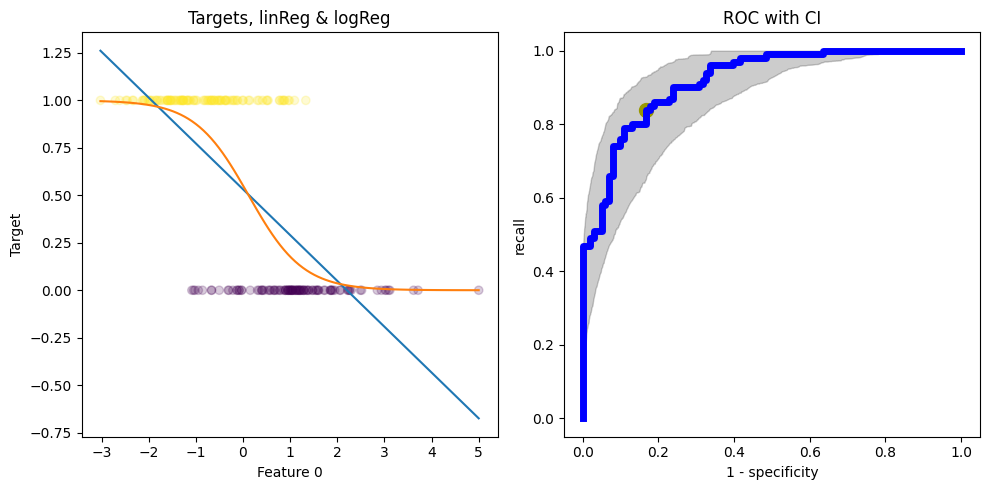

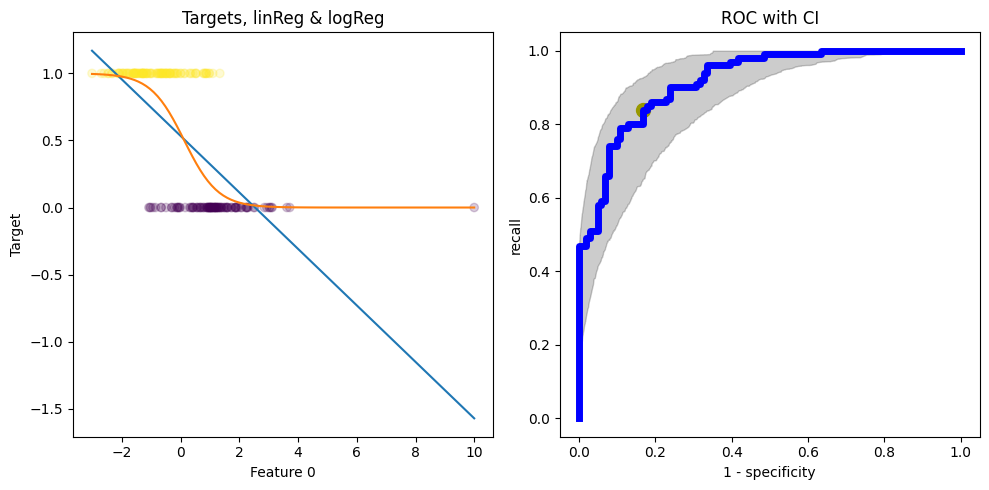

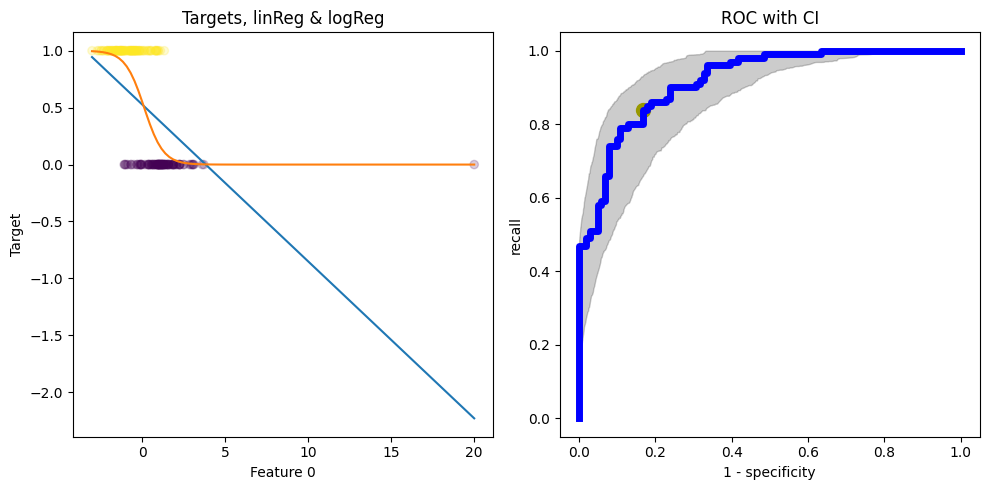

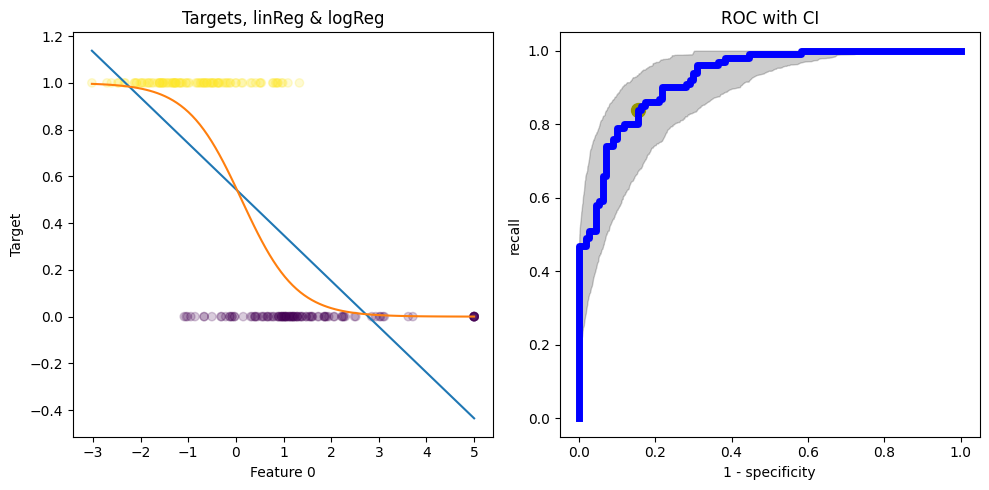

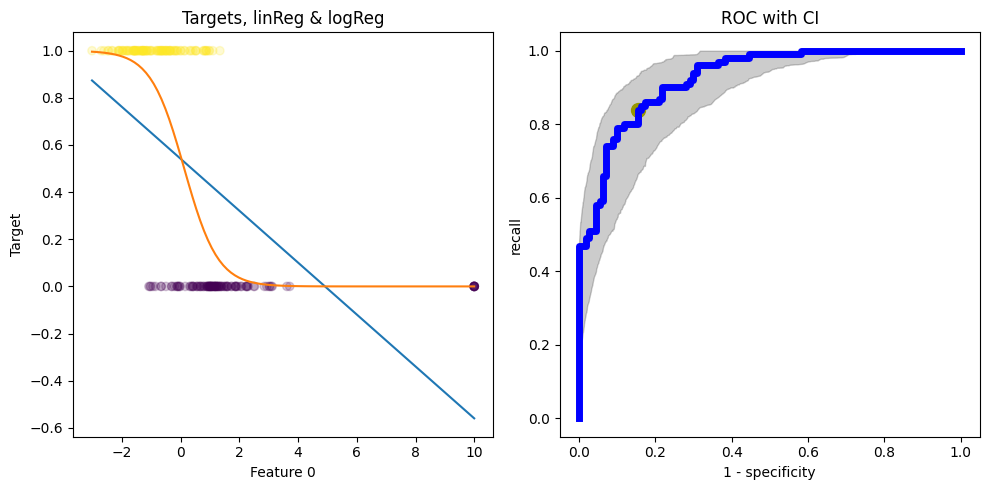

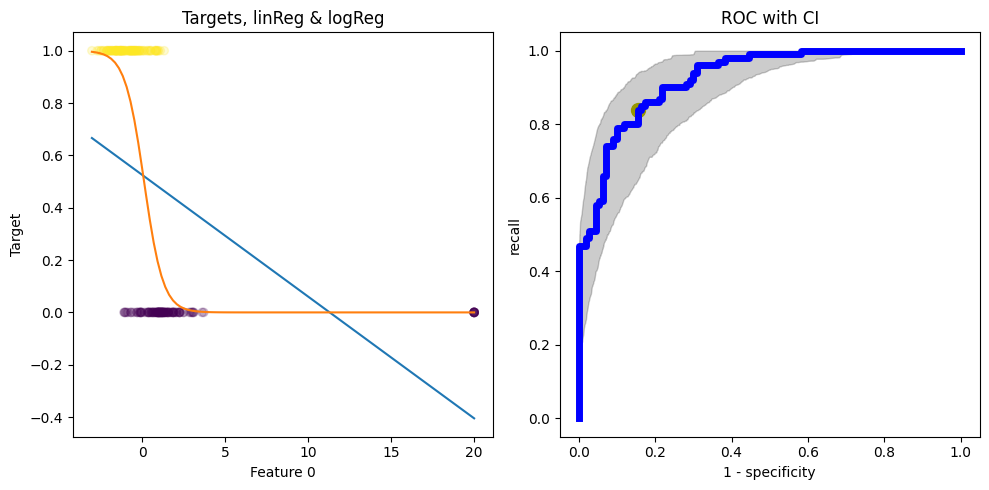

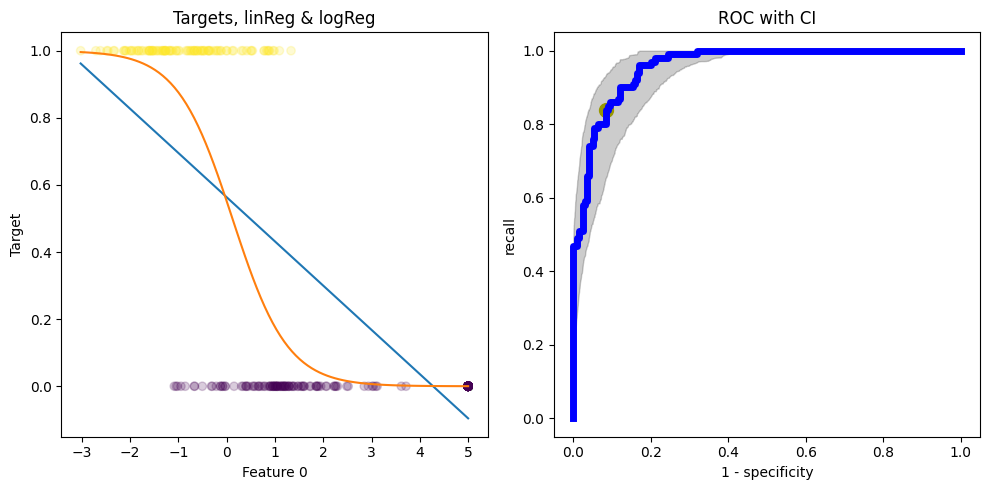

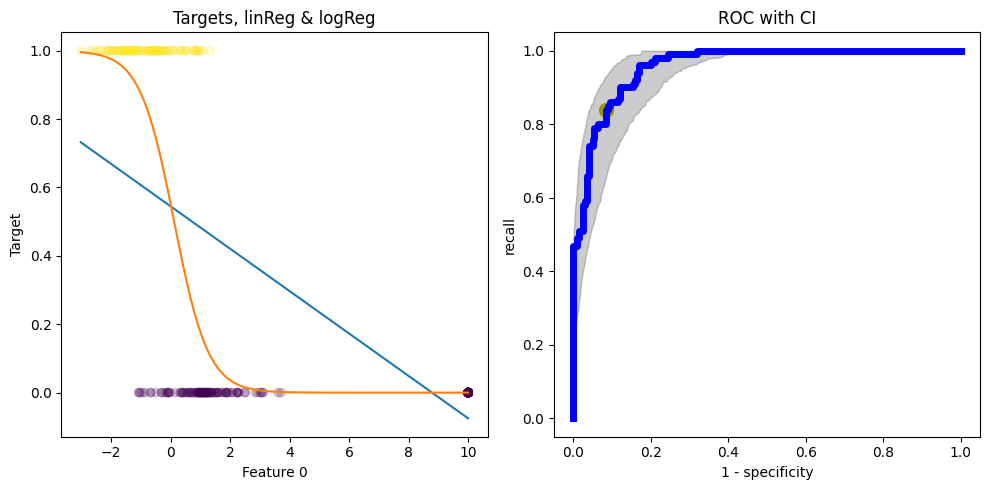

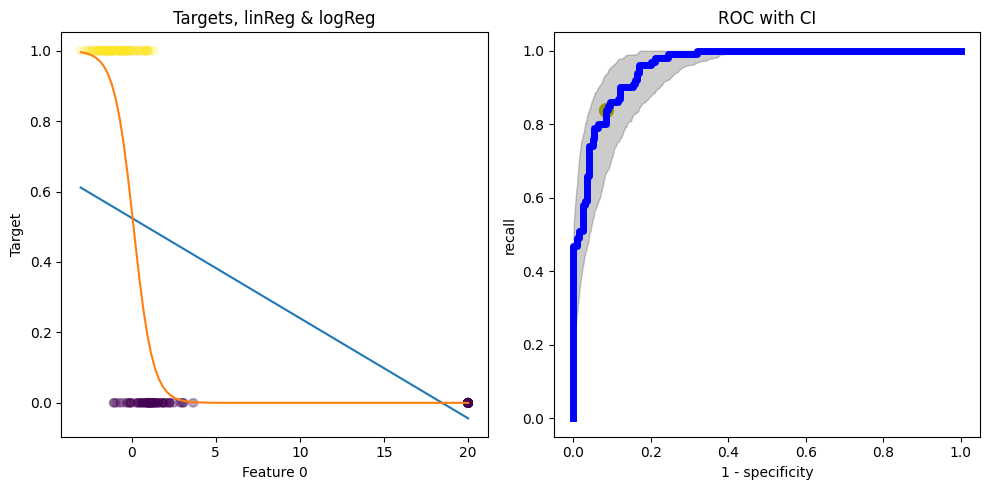

In [ ]:
selected_classes = [0, 1]
selected_feature = 0


def draw_model(x, model_instance):
    x_draw = np.reshape(np.linspace(x.min(), x.max(), 100), (-1, 1))
    y_draw = model_instance.predict(x_draw) if type(model_instance) == LinearRegression else model_instance.predict_proba(x_draw)[:, 1]
    plt.plot(x_draw, y_draw)

def draw_roc_curve(x, y, model_instance, target_class, threshold):
    fpr, tpr, thresholds = roc_curve(y, model_instance.predict_proba(x)[:, target_class], pos_label=target_class, drop_intermediate=False)
    nearest_index = np.argmin(np.abs(np.flip(thresholds) - threshold))

    plt.plot(fpr, tpr, color='blue', linewidth=5)
    plt.scatter(fpr[nearest_index], tpr[nearest_index], c='y', marker='o', s=100)

def draw_confidence_interval(bootstrap_samples, model_instance, target_class):
    fprs, tprs, thresholds = [], [], []
    for sample in bootstrap_samples:
        fpr, tpr, thresholds_ = roc_curve(sample[:, 1], model_instance.predict_proba(np.reshape(sample[:, 0], (-1, 1)))[:, target_class], pos_label=target_class)
        fprs.append(fpr)
        tprs.append(tpr)

        thresholds_[thresholds_ > 1] = 1
        thresholds_ = np.flip(thresholds_)
        thresholds.append(thresholds_)

    new_thresholds = np.linspace(0, 1, 1000)

    interpolated_fprs = []
    interpolated_tprs = []
    for fpr, tpr, thresholds_ in zip(fprs, tprs, thresholds):
        interpolated_fprs.append(np.interp(new_thresholds, thresholds_, fpr))
        interpolated_tprs.append(np.interp(new_thresholds, thresholds_, tpr))

    interpolated_fprs = np.array(interpolated_fprs)
    interpolated_tprs = np.array(interpolated_tprs)

    fpr_lower = np.percentile(interpolated_fprs, 2.5, axis=0)
    fpr_upper = np.percentile(interpolated_fprs, 97.5, axis=0)
    tpr_lower = np.percentile(interpolated_tprs, 2.5, axis=0)
    tpr_upper = np.percentile(interpolated_tprs, 97.5, axis=0)

    mean_fpr = np.mean(interpolated_fprs, axis=0)
    mean_tpr = np.mean(interpolated_tprs, axis=0)

    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='k', alpha=0.2, label='95% Confidence Interval (TPR)')


def draw_regression(df, target_class, threshold):
    if len(df.columns) != 2:
        df_reduced = df[[selected_feature, 'target']][df['target'].isin(selected_classes)]
        x = np.reshape(df_reduced[selected_feature].to_numpy(), (-1, 1))
    else:
        df_reduced = df
        x = np.reshape(df_reduced['feature'].to_numpy(), (-1, 1))

    y = df_reduced['target'].to_numpy()

    linear_regression = LinearRegression()
    linear_regression.fit(x, y)

    logistic_regression = LogisticRegression()
    logistic_regression.fit(x, y)

    plt.figure(figsize=(10,5))

    plt.subplot(121)
    plt.title('Targets, linReg & logReg')
    plt.xlabel(f'Feature {selected_feature}')
    plt.ylabel('Target')
    plt.scatter(x, y, c=y, alpha=0.2)
    draw_model(x, linear_regression)
    draw_model(x, logistic_regression)

    plt.subplot(122)
    plt.title('ROC with CI')
    plt.xlabel('1 - specificity')
    plt.ylabel('recall')
    draw_roc_curve(x, y, logistic_regression, target_class, threshold)

    data = np.array(list(zip(x.ravel(), y)))

    bootstrap_samples = np.array([np.array([data[random.randint(0, len(x) - 1)] for _ in range(len(y))]) for _ in range(1000)])
    draw_confidence_interval(bootstrap_samples, logistic_regression, target_class)

    plt.tight_layout()
    plt.show()


for a in df_multipliers_A:
    for b in df_coords_B:
        m = (a, b)
        draw_regression(repeat_df_dict[m], selected_classes[1], 0.5)


[5] Для выбранной пары классов (включая класс с повторенными объектами) на
всех признаках вычислить уравнение множественной линейной регрессии, где Y –
класс, Xi – признаки.
Используя полученные уравнения множественной линейной регрессии, на основе
каждого из датасетов df и df_A_B сформировать новые датасеты logdf и logdf_A_B,
в каждом из которых есть только один признак Х, сформированный на основе
соответствующего уравнения множественной линейной регрессии, а переменная Y
– отнесение к классу.

In [ ]:
def multiple_linear_regression(df, name):
    df_reduced = df[df['target'].isin(selected_classes)].reset_index(drop=True)
    x = df_reduced.drop('target', axis=1)
    x = x.drop('id', axis=1).to_numpy()
    y = df_reduced['target'].to_numpy()

    model = LinearRegression()
    model.fit(x, y)
    print(f'Equation for {name}: ({model.coef_[0]:.4f}) * f1 + ({model.coef_[1]:.4f}) * f2 + ({model.coef_[2]:.4f}) * f3 + ({model.coef_[3]:.4f}) * f4 + ({model.intercept_:.4f})')

    log_df = pd.DataFrame({'feature': model.coef_[0] * x[:, 0] +
                                      model.coef_[1] * x[:, 1] +
                                      model.coef_[2] * x[:, 2] +
                                      model.coef_[3] * x[:, 3] +
                                      model.intercept_, 'target': df_reduced['target']})
    return log_df

[6] Для каждого из датасетов logdf и logdf_A_B в своем пространстве Х-Y
(количественный признак-класс) построить и визуализировать объекты, линию
простой линейной регрессии и линию логистической регрессии. Регрессии строить
на паре Х-Y( количественный признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые и восстановив на графике ROC кривых
точку классификации Sensitivity-Specificity и доверительные интервалы CI95.
Все полученные графики возможно расположить в две колонки.

Equation for Default: (-0.1001) * f1 + (-0.1190) * f2 + (-0.0681) * f3 + (-0.1181) * f4 + (0.5016)
Equation for df[(1, 5)]: (-0.1139) * f1 + (-0.1064) * f2 + (-0.0824) * f3 + (-0.1039) * f4 + (0.5004)


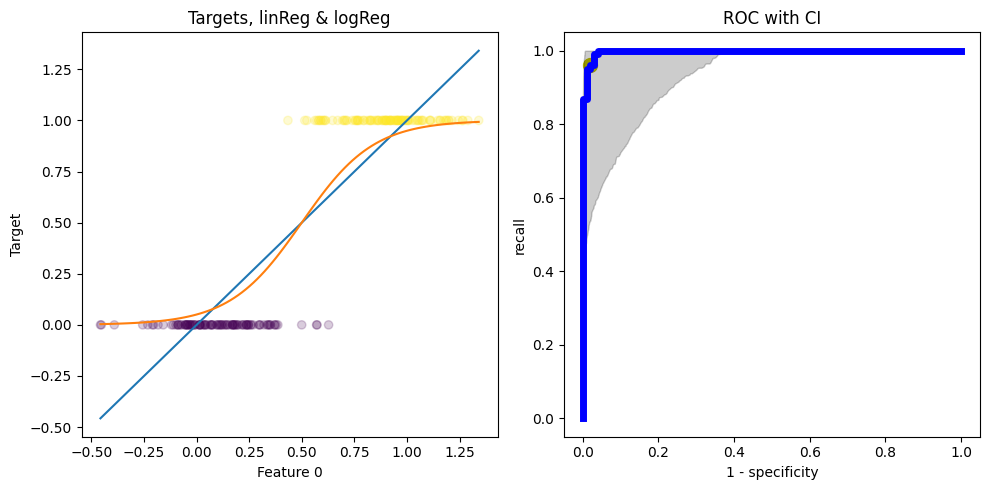

Equation for df[(1, 10)]: (-0.1200) * f1 + (-0.1008) * f2 + (-0.0884) * f3 + (-0.0980) * f4 + (0.5019)


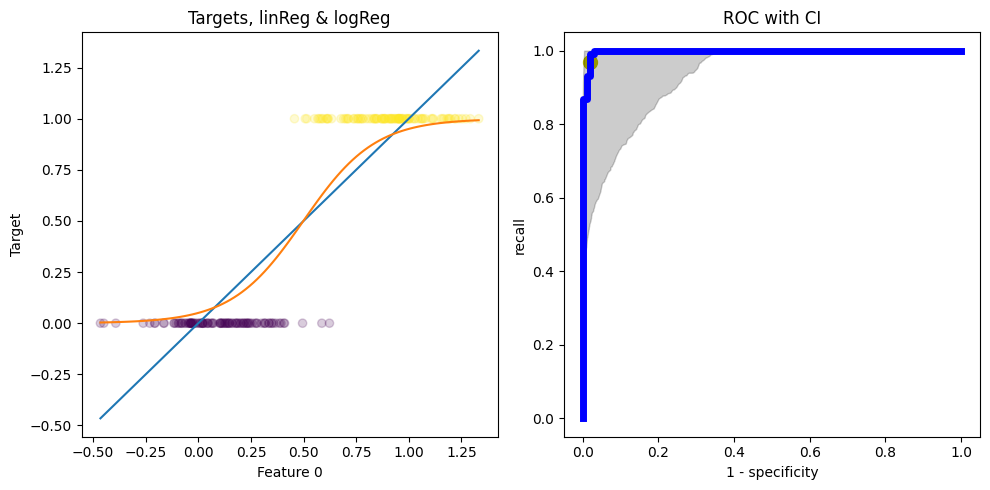

Equation for df[(1, 20)]: (-0.1213) * f1 + (-0.0996) * f2 + (-0.0895) * f3 + (-0.0968) * f4 + (0.5031)


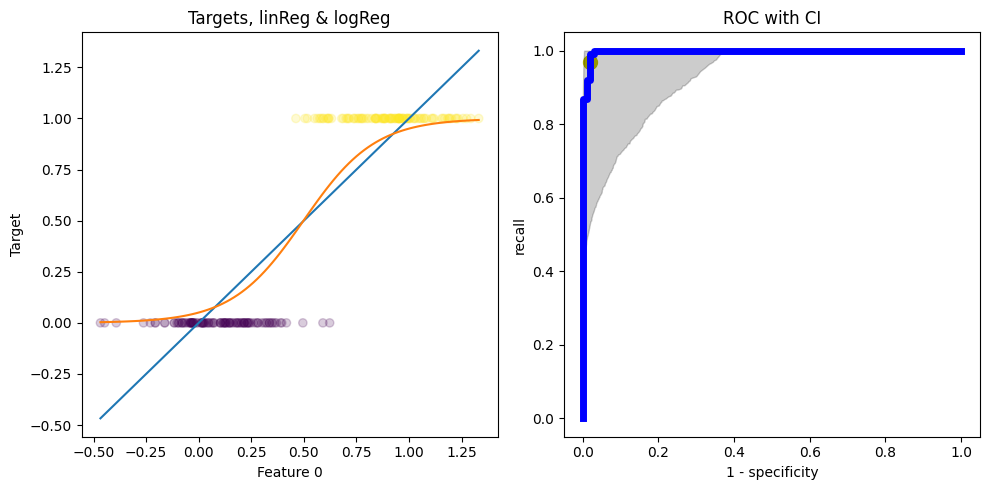

Equation for df[(10, 5)]: (-0.1353) * f1 + (-0.0869) * f2 + (-0.1044) * f3 + (-0.0821) * f4 + (0.4985)


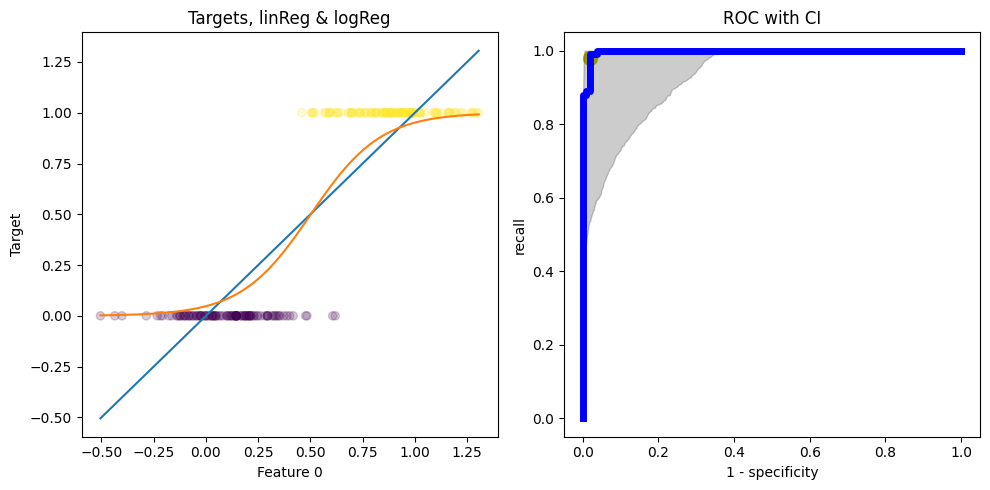

Equation for df[(10, 10)]: (-0.1289) * f1 + (-0.0928) * f2 + (-0.0973) * f3 + (-0.0891) * f4 + (0.5021)


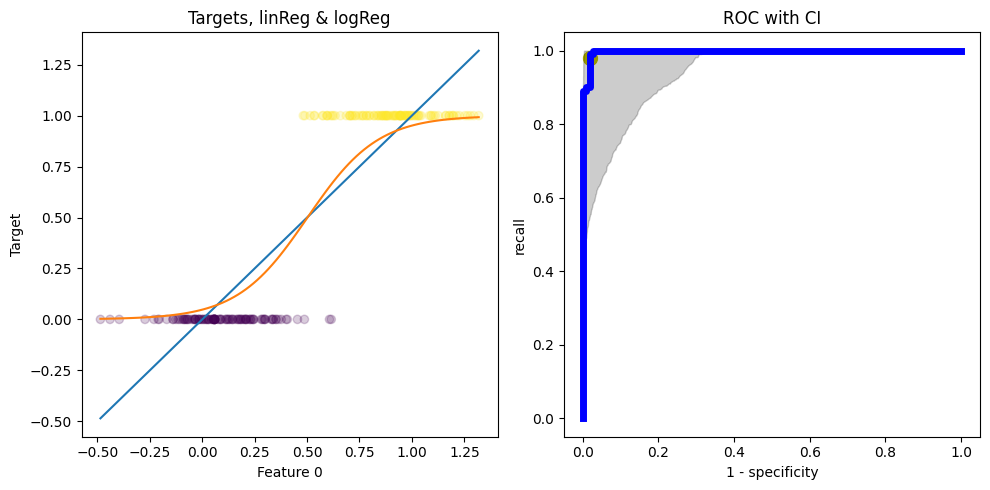

Equation for df[(10, 20)]: (-0.1238) * f1 + (-0.0974) * f2 + (-0.0920) * f3 + (-0.0944) * f4 + (0.5032)


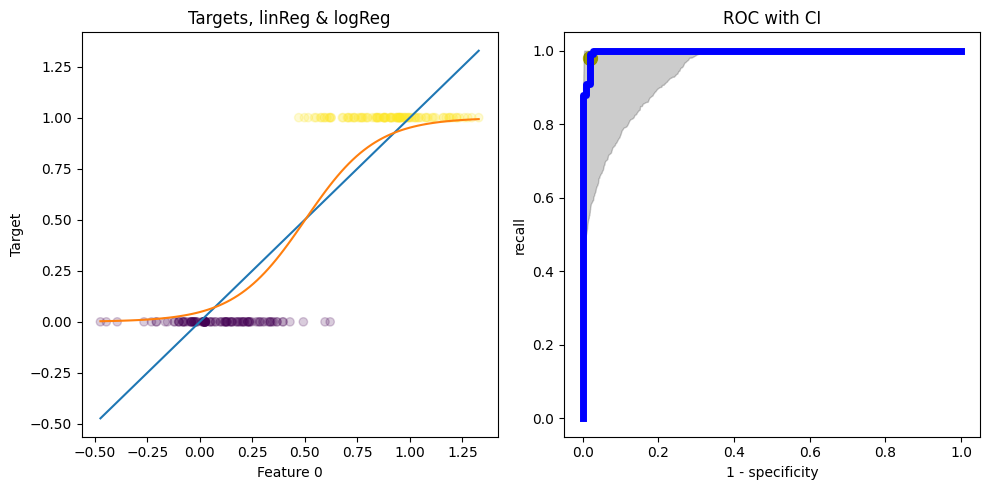

Equation for df[(100, 5)]: (-0.1417) * f1 + (-0.0811) * f2 + (-0.1111) * f3 + (-0.0755) * f4 + (0.4980)


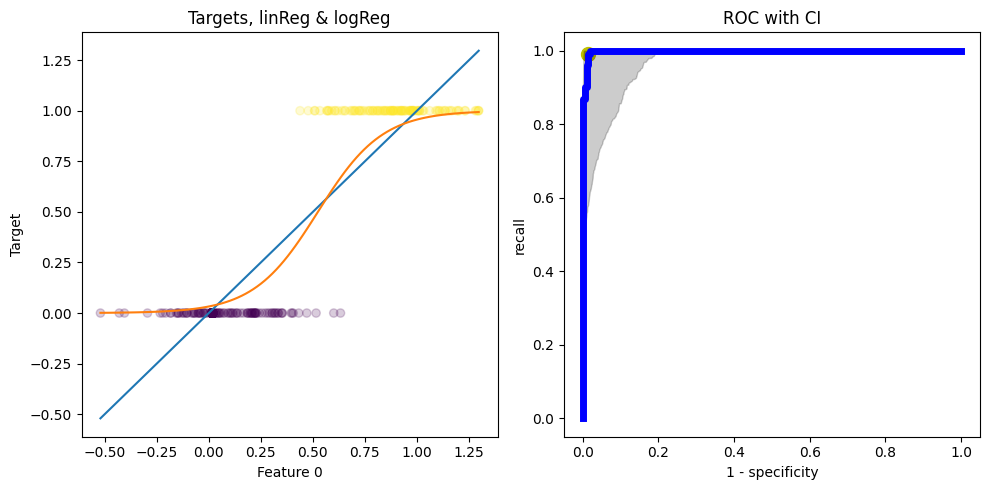

Equation for df[(100, 10)]: (-0.1302) * f1 + (-0.0916) * f2 + (-0.0987) * f3 + (-0.0878) * f4 + (0.5021)


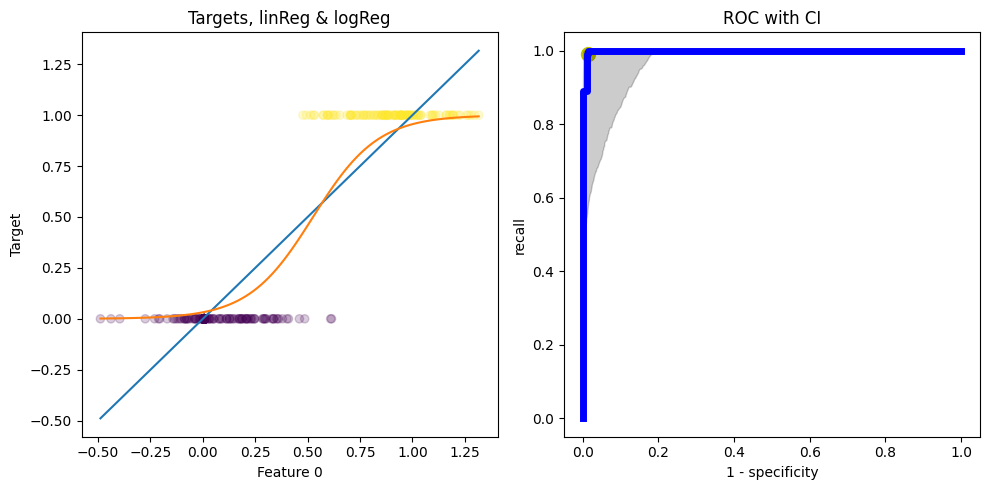

Equation for df[(100, 20)]: (-0.1241) * f1 + (-0.0972) * f2 + (-0.0923) * f3 + (-0.0941) * f4 + (0.5033)


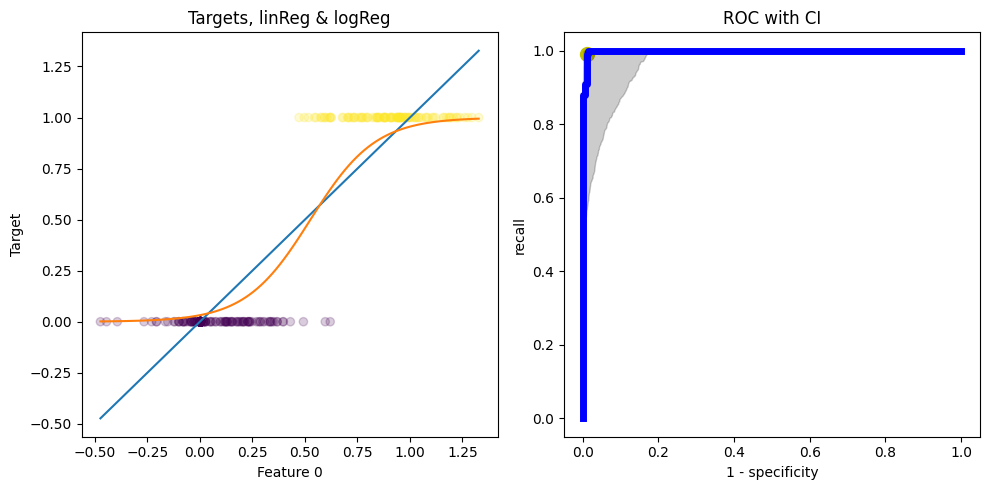

In [ ]:
logdf = multiple_linear_regression(df, 'Default')

logdfs = {}

for a in df_multipliers_A:
    for b in df_coords_B:
        m = (a, b)
        logdfs[m] = multiple_linear_regression(repeat_df_dict[m], f'df[({a}, {b})]')
        draw_regression(logdfs[m], selected_classes[1], 0.5)


[7] Для выбранной пары классов (включая класс с повторенными объектами),
визуализировать один из датасетов df_A_B на всех парах переменных, построив
на графиках объекты, линии множественной линейной регрессии, разделение
классов на основе логистической регрессии решающей функцией с contour_plot
уровнями классификации.

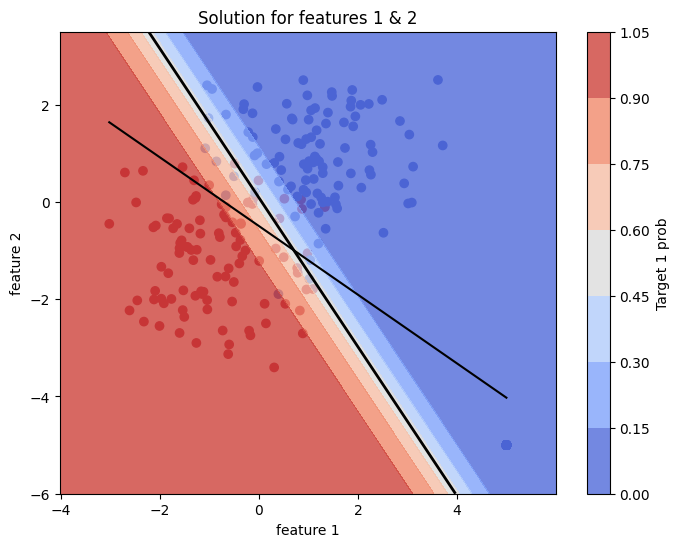

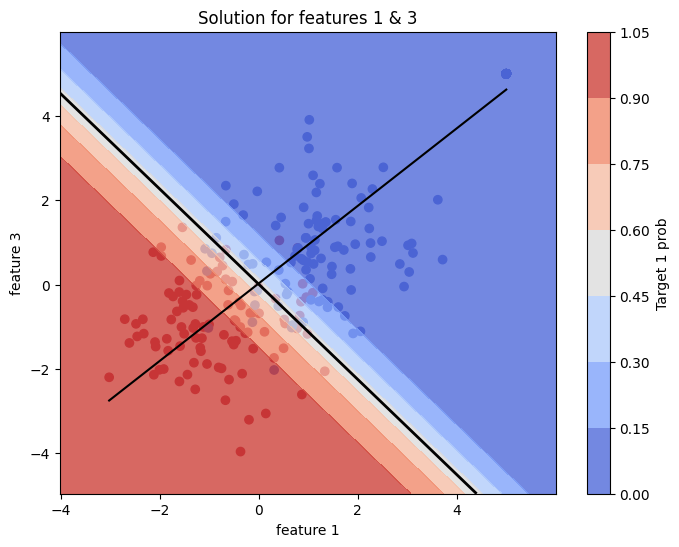

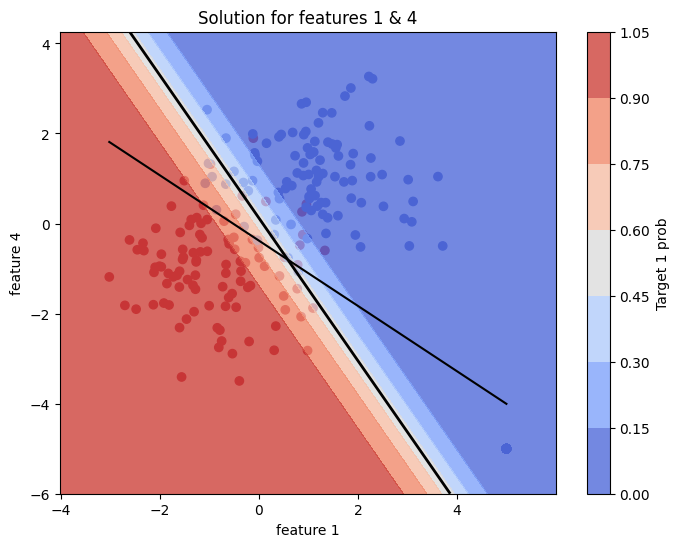

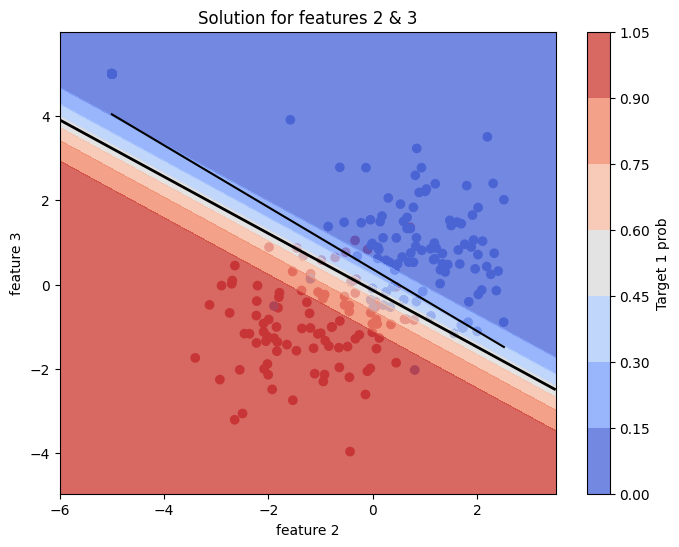

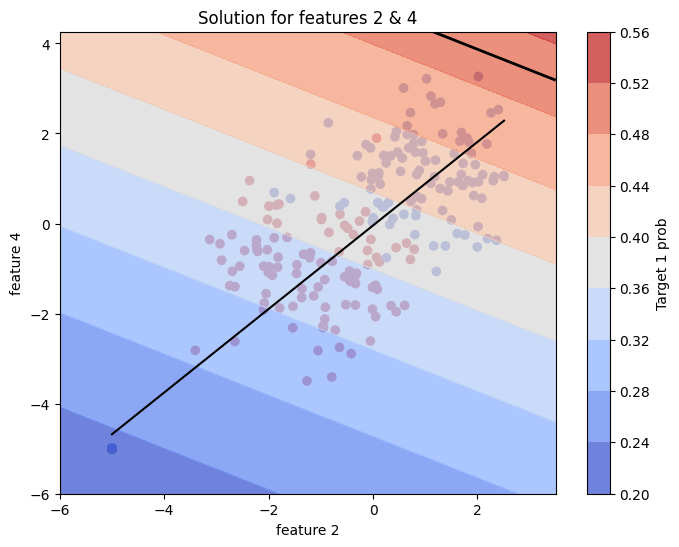

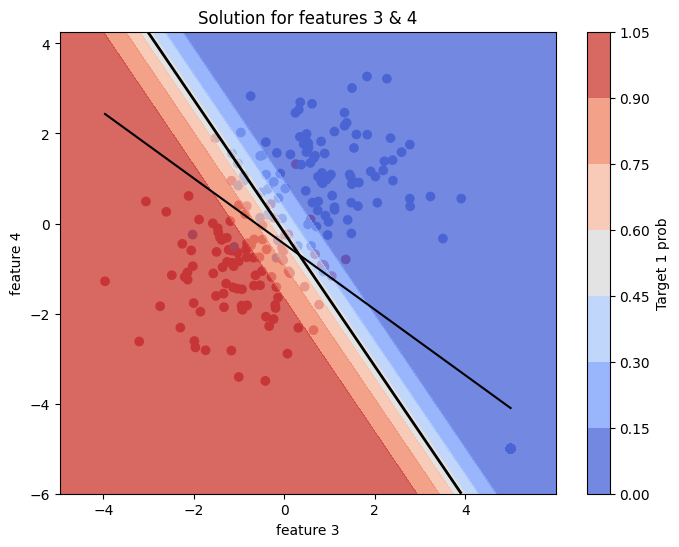

In [ ]:


def visualize(df):
    df_reduced = df[df['target'].isin(selected_classes)].reset_index(drop=True)
    x = df_reduced.drop('target', axis=1).to_numpy()
    y = df_reduced['target'].to_numpy()

    feature_pairs = list(combinations([0, 1, 2, 3], 2))

    for i in range(len(feature_pairs)):
        plt.figure(figsize=(8, 6))
        plt.scatter(x[:, feature_pairs[i][0]], x[:, feature_pairs[i][1]], c=y, cmap='coolwarm')
        plt.xlabel(f'feature {feature_pairs[i][0]+1}')
        plt.ylabel(f'feature {feature_pairs[i][1]+1}')

        linear_regression = LinearRegression()
        linear_regression.fit(np.reshape(x[:, feature_pairs[i][0]], (-1, 1)), x[:, feature_pairs[i][1]])
        linear_x = np.linspace(x[:, feature_pairs[i][0]].min(), x[:, feature_pairs[i][0]].max(), 100)
        plt.plot(linear_x, linear_regression.predict(np.reshape(linear_x, (-1, 1))), label='LinReg', color='black')

        logistic_regression = LogisticRegression()

        x_data = np.column_stack((x[:, feature_pairs[i][0]], x[:, feature_pairs[i][1]]))
        logistic_regression.fit(x_data, y)

        h = .02
        x_min, x_max = x[:, feature_pairs[i][0]].min() - 1, x[:, feature_pairs[i][0]].max() + 1
        y_min, y_max = x[:, feature_pairs[i][1]].min() - 1, x[:, feature_pairs[i][1]].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        Z_prob = logistic_regression.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z_prob = Z_prob.reshape(xx.shape)


        contour = plt.contourf(xx, yy, Z_prob, alpha=0.8, cmap='coolwarm')

        plt.contour(xx, yy, Z_prob, levels=[0.5], colors='black', linewidths=2)

        plt.colorbar(contour, label='Target 1 prob')

        plt.title(f'Solution for features {feature_pairs[i][0]+1} & {feature_pairs[i][1]+1}')
        plt.show()


visualize(outweighted_df)
